# Denoising Diffusion Probabilistic Models demo


*This tutorial is intended for readers who have a basic understanding of mathematics and deep neural networks.

*While this is a novel implementation, it cannot be ignored that it was inspired by many existing tutorials or blog posts.

# INTRODUCTION

OpenAI has another star product besides the recently popular GPT, called DALL-E. DALL-E uses the diffusion model to create realistic images and art from natural language descriptions. (Anyone interested in this tutorial should try DALL-E 2(https://openai.com/product/dall-e-2), as it will open your eyes to the potential of the diffusion model.) Of course, this tutorial does not aim to replicate DALL-E, as it is too complex to be trained on a personal computer and is an industrial-grade product with many tricks. Instead, this tutorial will focus on the paper *Denoising Diffusion Probabilistic Models* [HJA20], which started the era of diffusion models. We will attempt to reproduce the algorithms from the paper on a small dataset and explain some of the mathematical principles involved.

By definition, diffusion models, also known as diffusion probabilistic models, are a class of latent variable models. They are Markov chains trained using variational inference [HJA20]. Of course, such a definition can be confusing to those unfamiliar with diffusion models. In this tutorial, we will use an example to explain the diffusion model more clearly:

**Aim**

Imagine that you have a lot of pictures of cats. You want the machine learning algorithm to learn patterns from them and generate more pictures of cats.

**Declaration of symbols**
* $t$ for steps
* $T$ Maximum number of steps 
* $x$ for a data (In this case it refers to a picture of cat)
* $\beta$ for learning rate ($\beta$ is not a number but a list, which $len(\beta) = T $)
* $\epsilon$ for random noise subject to gaussian distribution

**Training process**
* REPEAT
  * t = 0, select a picture of a cat from the dataset, named as $x_0$
  * t = 1, $x_1 = x_0 + \beta_1 \cdot \epsilon_1 $ 
    * Pass t = 1, $x_1$, $\beta_1$ and $\epsilon_1$ to the neural network
    * The neural network performs supervised learning and distinguishes which part of $x_1$ is the noise
  * t = 2, $x_2 = x_1 + \beta_2 \cdot \epsilon_2 $ 
    * Pass t = 2, $x_2$, $\beta_2$ and $\epsilon_2$ to the neural network
    * ...
  * ...
  * t = T, end
* UNTIL neural networks converged

**Sampling process**
* t = T, generate a random noise picture, named as $x_T$.
* t = T-1, based on distribution $q\left(\mathbf{x}_{T-1} \mid \mathbf{x}_T, \mathbf{x}_0\right)$, sample $x_{T-1}$
* t = T-2, based on distribution $q\left(\mathbf{x}_{T-2} \mid \mathbf{x}_{T-1}, \mathbf{x}_0\right)$, sample $x_{T-2}$
* ...
* ...
* t = 0, based on distribution $q\left(\mathbf{x}_{0} \mid \mathbf{x}_{1}, \mathbf{x}_0\right)$, sample $x_{1}$
* RETURN $x_0$

**Addition**
* $T$ and $\beta$ are hyperparameters that set manually, how to choice in **Set hyperparameters** section
* We assume that the noise all obeys a Gaussian distribution, detail in **Limitations** section
* This pseudocode is only a rough explanation of the algorithm, full version in **Algorithm** section
* Note that the noise of the **Training process** and the **Sampling process** obey different distributions. For this we need to perform a complex mathematical derivation, detail in **Forward diffusion** and **Reverse diffusion** section

# BACKGROUND

**Declaration**
* **Forward diffusion** for Training process or Learning process
* **Reverse diffusion** for Sampling process or Generating process
* $p$ for the Forward diffusion e.g. $p(x_t)$ denotes the data in the forward diffusion
* $q$ for the Reverse diffusion
* $\alpha_t$ = 1 - $\beta_t$

## Forward diffusion

**Declaration** 
* All $x_t$ in this section indicate the data in the Forward diffusion

The central goal of forward diffusion is to find $x_t$ by $x_{t-1}$:
$$
x_t = x_{t-1} + \beta_t \cdot \epsilon_t \quad \epsilon_t \sim N\left(0, \sigma^2\right) \quad \quad \quad \quad \quad \quad (1)
$$ 

By *Linear combinations of normal random variables* [N06], combine $\epsilon$ and $\sigma^2$:

$$
x_t = x_{t-1} + \beta_t \cdot \epsilon_t \quad \epsilon_t \sim N\left(0, I\right) \quad \quad \quad \quad \quad \quad (2)
$$ 

Use *exponential moving average* style to express:
$$
x_t=\alpha \cdot x_{t-1}+(\alpha-1) \cdot z \quad z \sim N(0, I) \quad \quad \quad \quad \quad \quad (3)
$$

I think this may be to ensure that the final reduced form is simple and to control the curve of the learning rate change. $\sqrt{\alpha}$ and $\sqrt{\alpha-1}$ used by the authors of DDMP [HJA20]: 
$$
x_t=\sqrt{\alpha} \cdot x_{t-1}+\sqrt{\alpha-1} \cdot z_1 \quad z_1 \sim N(0, I) \quad \quad \quad \quad \quad \quad (4)
$$

Calculate $x_{t-1}$ using equation $(4)$:
$$
x_{t-1}=\sqrt{\alpha} \cdot x_{t-2}+\sqrt{\alpha-1} \cdot z_2 \quad z_2 \sim N(0, I) \quad \quad \quad \quad \quad \quad (5)
$$

Replace the $x_{t-1}$ in $(4)$ with $(5)$:
$$
x_t=\sqrt{\alpha_t}\left(\sqrt{\alpha_{t-1}} \cdot x_{t-2}+\sqrt{1-\alpha_{t-1}} \cdot z_2\right)+\sqrt{1-\alpha_t} \cdot z_1 \quad z_1, z_2 \sim N(0, I) \quad \quad \quad \quad \quad \quad (6)
$$

Expand $(6)$:
$$
x_t=\sqrt{\alpha_t \alpha_{t-1}} \cdot x_{t-2}+\left(\sqrt{\alpha_t\left(1-\alpha_{t-1}\right)} \cdot z_2+\sqrt{1-\alpha_t} \cdot z_1\right) \quad z_1, z_2 \sim N(0, I) \quad \quad \quad \quad \quad \quad (7)
$$

Simplify $(7)$ by *Linear combinations of normal random variables* [N06]:
$$
x_t=\sqrt{\alpha_t \alpha_{t-1}} \cdot x_{t-2}+\sqrt{1-\alpha_t \alpha_{t-1}} \cdot z \quad z \sim N(0, I) \quad \quad \quad \quad \quad \quad (8)
$$

Recursion and using mathematical induction:
$$
x_t=\sqrt{\bar{\alpha}_t} \cdot x_0+\sqrt{1-\bar{\alpha}_t} \cdot z \quad z \sim N(0, I) \quad \quad \quad \quad \quad \quad (9)
$$
$$
where \quad \bar{\alpha} = \alpha_1 \cdot \alpha_2 \cdots  \alpha_{t-1} \cdot \alpha_t
$$

With equation $(9)$ we can calculate $x_t$ directly using $x_0$ without going through intermediate iterations.

## Reverse diffusion

**Declaration** 
* All $x_t$ in this section indicate the data in the Reverse diffusion

The central goal of reverse diffusion is to find $x_{t-1}$ by $x_t$. But we have no way to solve it directly and have to turn to the probability distribution: 
$$
q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0\right) \quad \quad \quad \quad \quad \quad (10)
$$

According to the Bayesian formula：
$$
q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0\right)=q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}, \mathbf{x}_0\right) \frac{q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_0\right)}{q\left(\mathbf{x}_t \mid \mathbf{x}_0\right)} \quad \quad \quad \quad \quad \quad (11)
$$

According to equation $(4)$, we have:
$$
q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}, \mathbf{x}_0\right)=\sqrt{\alpha_t} \cdot x_{t-1}+\sqrt{1-\alpha_t} \cdot z  \quad \quad \quad \quad \quad \quad (12)
$$

According to equation $(9)$, we have:
$$
q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_0\right) = \sqrt{\bar{\alpha}_{t-1}} \cdot x_0+\sqrt{1-\bar{\alpha}_{t-1}} \cdot z  \quad \quad \quad \quad \quad \quad (13)
$$

$$
q\left(\mathbf{x}_{t} \mid \mathbf{x}_0\right) = \sqrt{\bar{\alpha}_{t}} \cdot x_0+\sqrt{1-\bar{\alpha}_{t}} \cdot z  \quad \quad \quad \quad \quad \quad (14)
$$

Equation $(12), (13), (14)$ can be considered as following a normal distribution:
$$
q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}, \mathbf{x}_0\right) \quad \sim \quad N\left(\sqrt{\alpha_t} \cdot x_{t-1}, \quad 1-\alpha_t\right)  \quad \quad \quad \quad \quad \quad (15)
$$
$$
q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_0\right) \quad \sim \quad N\left(\sqrt{\bar{\alpha}_{t-1}} \cdot x_0, \quad 1-\bar{\alpha}_{t-1}\right)  \quad \quad \quad \quad \quad \quad (16)
$$
$$
q\left(\mathbf{x}_t \mid \mathbf{x}_0\right) \quad \sim \quad N\left(\sqrt{\bar{\alpha}_t} \cdot x_0, \quad 1-\bar{\alpha}_t\right)  \quad \quad \quad \quad \quad \quad (17)
$$

The probability density function of the normal distribution is:
$$
f(x)=\frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{(x-\mu)^2}{2 \sigma^2}\right) \quad \quad \quad \quad \quad \quad (18)
$$

Transforming $(15),(16),(17)$ into a probability density function, by *linear combinations of normal random variables* [N06], we have:
$$
q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0\right) \propto \exp \left(-\frac{1}{2}\left(\frac{\left(\mathbf{x}_t-\sqrt{\alpha_t} \mathbf{x}_{t-1}\right)^2}{\beta_t}+\frac{\left(\mathbf{x}_{t-1}-\sqrt{\bar{\alpha}_{t-1}} \mathbf{x}_0\right)^2}{1-\bar{\alpha}_{t-1}}-\frac{\left(\mathbf{x}_t-\sqrt{\bar{\alpha}_t} \mathbf{x}_0\right)^2}{1-\bar{\alpha}_t}\right)\right) \quad \quad \quad \quad \quad \quad (19)
$$

Simplify $(19)$:
$$
=\exp \left(-\frac{1}{2}\left(\frac{\mathbf{x}_t^2-2 \sqrt{\alpha_t} \mathbf{x}_t \mathbf{x}_{t-1}+\alpha_t \mathbf{x}_{t-1}^2}{\beta_t}+\frac{\mathbf{x}_{t-1}^2-2 \sqrt{\bar{\alpha}_{t-1}} \mathbf{x}_0 \mathbf{x}_{t-1}+\bar{\alpha}_{t-1} \mathbf{x}_0^2}{1-\bar{\alpha}_{t-1}}-\frac{\left(\mathbf{x}_t-\sqrt{\bar{\alpha}_t} \mathbf{x}_0\right)^2}{1-\bar{\alpha}_t}\right)\right) \quad \quad \quad \quad \quad \quad (20)
$$

Combining like terms of $(20)$, we only concern the term related to $x_{t-1}$:
$$
=\exp \left(-\frac{1}{2}\left(\left(\frac{\alpha_t}{\beta_t}+\frac{1}{1-\bar{\alpha}_{t-1}}\right) x_{t-1}^2-\left(\frac{2 \sqrt{\alpha_t}}{\beta_t} \mathbf{x}_t+\frac{2 \sqrt{\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_{t-1}} \mathbf{x}_0\right) \mathbf{x}_{t-1}+C\left(\mathbf{x}_t, \mathbf{x}_0\right)\right)\right) \quad \quad \quad \quad \quad \quad (21)
$$

Expanding $(18)$, we can obtain:
$$
\exp \left(-\frac{(x-\mu)^2}{2 \sigma^2}\right)=\exp \left(-\frac{1}{2}\left(\frac{1}{\sigma^2} x^2-\frac{2 \mu}{\sigma^2} x+\frac{\mu^2}{\sigma^2}\right)\right) \quad \quad \quad \quad \quad \quad (22)
$$

Comparing $(22)$ with $(21)$, we can get the distribution of $(10)$:
$$
q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \tilde{\boldsymbol{\mu}}_t\left(\mathbf{x}_t, \mathbf{x}_0\right), \tilde{\beta}_t \mathbf{I}\right) \quad \quad \quad \quad \quad \quad (23)
$$


$$
where \quad \tilde{\boldsymbol{\mu}}_t\left(\mathbf{x}_t, \mathbf{x}_0\right):=\frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1-\bar{\alpha}_t} \mathbf{x}_0+\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} \mathbf{x}_t \quad  \quad \quad \quad \quad \quad \quad (24)
$$
$$
and \quad \tilde{\beta}_t:=\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t  \quad \quad \quad \quad \quad \quad (25)
$$

Notice that $x_0$ in $(24)$ is unknown, use $(9)$ to replace:
$$
\tilde{\boldsymbol{\mu}}_t\left(\mathbf{x}_t, \mathbf{x}_0\right)=\frac{1}{\sqrt{a_t}}\left(x_t-\frac{\beta_t}{\sqrt{1-\bar{a}_t}} z_t\right) \quad \quad \quad \quad \quad \quad (26)
$$

Of course, $z_t$ is still unknown, but we can learn it through neural networks.

## Algorithm

The original algorithm in DDPM [HJA20] is placed here for reference purposes only. Attempting to understand the algorithm itself directly is difficult and should rely on the specific experiments in **DATASET**, **METHOD** and **RESULT** for understanding

**Algorithm 1 Training**
* repeat
  * $\mathbf{x}_0\sim q(\mathbf{x}_0)$
  * $t\sim\ Uniform (\{1,...,T\})$
  * $\epsilon\sim\mathcal{N}(\mathbf{0},\mathbf{I})$
  * Take gradient descent step on $\nabla_\theta\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0+\sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon},t)\right\|^2$
* until converged 

**Algorithm 2 Sampling**
* $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0},\mathbf{I})$
* for $t=T,\ldots,1$ do
  * $\mathbf{z}\sim\mathcal{N}(\mathbf{0},\mathbf{I})$ if $t>1$, else $z=0$
  * $\mathbf{x}_{t-1}=\frac{1}{\sqrt{\alpha_{t}}}\left(\mathbf{x}_{t}-\frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha}_{t}}}\epsilon_{\theta}(\mathbf{x}_{t},t)\right)+\sigma_{t}\mathbf{z}$
* end for
* return $x_0$

# DATASET

In order to minimize the running time, it is not feasible to train a model to learn how to draw a cat. Instead, we use the 2D point set provided by sklearn. Each point has two coordinates $x, y$ where $x,y\in(-1,1)$. They all lie on the same circle, visualised in **Load data** section *Fig1*.

Imagine each point as a picture of a cat. The "circle" represents the abstract concept of "cat". Whether a point falls on a circle or not corresponds to whether a picture is a cat or not. Thus, Fig1 does not correspond to a single image or a single piece of data. fig1 show a dataset of several hundred pieces of data!

## Setup

This tutorial requires very few external libraries. matplotlib for Visualisation, sklearn for datasets, torch for create neural networks easily.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_circles

## Load data

In a diffusion model, the richness of the dataset is crucial. For instance, if only a few dozen cat pictures are provided to the diffusion model, it can only sample from these pictures repeatedly during the training process. This may cause extremely poor training results or a failure to converge.

Therefore, we sampled 500 points to create a dataset. Such a quantity is sufficient to show regularity without requiring excessive training time.

shape of dataset: torch.Size([500, 2])


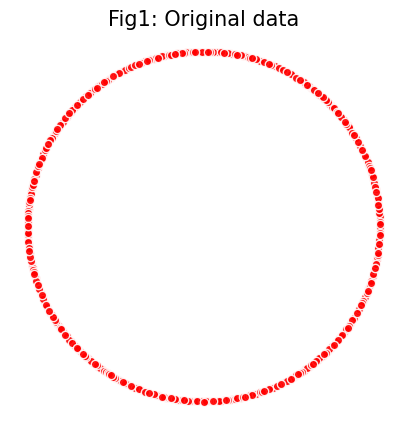

In [2]:
# Sampling with sklearn's make_circles as training set
dataset, _ = make_circles(n_samples=(500, 0))

# Plotting all the data into the same image
fig1, ax = plt.subplots(figsize=(5, 5), facecolor='white')
ax.set_title('Fig1: Original data', fontdict={'color': 'black', 'size': 15})
ax.scatter(*dataset.T, color='red', edgecolor='White', alpha=0.9)
ax.axis('off')

# Set the data as a floating point tensor
dataset = torch.Tensor(dataset).float()

# Show the shape of dataset
print("shape of dataset:", dataset.shape)

# METHOD

In this chapter we will complete all the preparations before training the model

## Hyperparameter pre-processing

* In the **Forward diffusion** section we know that equation $(9)$ is used to calculate $x_t$, so calculating $\sqrt{\bar{\alpha}_t}$ and $\sqrt{1-\bar{\alpha}_t}$ in advance avoids repeated calculations.

* In the previous section we mentioned that we need to set two hyperparameters $T$ and $\beta$. considering that $\beta$ is a list of length $T$, we cannot set every number for $\beta$, so we only give upper and lower bounds when setting the parameters and generate the middle value by the algorithm.
  * This tutorial uses the sigmoid function to generate the beta. (Other functions are also possible, such as linear functions. However, this depends on the characteristics of the data and the choice of neural network.)

In [3]:
def hyper_per_pro(num_steps, beta_start_end):
    """Hyperparameter pre-processing"""

    # Use upper bound, lower bound and T to generate betas by sigmoid
    betas = torch.linspace(-6, 6, num_steps)
    betas = torch.sigmoid(betas)*(beta_start_end[1] - beta_start_end[0])+beta_start_end[0]

    # Calculate alphas
    alphas = 1-betas
    # Calculate alphas cumprod, also called bar{alphas}
    alphas_cumprod = torch.cumprod(alphas, 0)
    # Square root calculations of alphas cumprod
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    # Square root calculations of one minus alphas cumprod
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

    return alphas, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod

## Forward diffusion

* Calculate $x_t$ by equation $(9)$.
  * Note that the noise we add will also be part of the return value, which will be used in the calculation of the error.

In [4]:
def forward_diffu(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    """based on x[0] to calculate x[t]"""

    # Randomly generated noise subject to standard normal distribution
    noise = torch.randn_like(x_0)

    # Calculate x_t by equation (9)
    x_t = sqrt_alphas_cumprod[t]*x_0 + sqrt_one_minus_alphas_cumprod[t]*noise

    return x_t, noise

## Build multilayer perceptron

Since the dataset is straightforward, we employ multiple perceptron machines:

**Declaration**
* Neural network with three layers A, B and C
* Each layer has 96 neurons
* Each neuron corresponds to $T$ adjustment values 
  * $T$ adjustment values corresponding to different values of $t$
  * Different neurons correspond to different adjustment values
  * In this tutorial the adjustment values are stored and trained by *Embedding*


**Pseudocode**
* Accept $x_t$ (A point with two parameters)
  * Fully connected with 96 neurons by a linear function
    * In layers A, each of the 96 neurons is added with the adjustment value
    * In layers A, ReLU activation function
  * Fully connected with 96 neurons by a linear function
    * In layers B, each of the 96 neurons is added with the adjustment value
    * ...
  * ...
  * Fully connected with 2 outputs by a linear function (The output is not the data, but the error which perceived by the model)
* Return $\epsilon_t$

**Addition**
* MLP is not a universal solution
  * Typically, U-Net performs well with image data $(224*224*3)$

In [5]:
class MLPDiffusion(torch.nn.Module):
    def __init__(self,n_steps,num_units=96):
        super(MLPDiffusion,self).__init__()
        
        self.linears = torch.nn.ModuleList(
            [
                torch.nn.Linear(2,num_units),
                torch.nn.ReLU(),
                torch.nn.Linear(num_units,num_units),
                torch.nn.ReLU(),
                torch.nn.Linear(num_units,num_units),
                torch.nn.ReLU(),
                torch.nn.Linear(num_units,2),
            ]
        )
        self.step_embeddings = torch.nn.ModuleList(
            [
                torch.nn.Embedding(n_steps,num_units),
                torch.nn.Embedding(n_steps,num_units),
                torch.nn.Embedding(n_steps,num_units),
            ]
        )
        
    def forward(self,x,t):
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
            
        x = self.linears[-1](x)
        
        return x

## Reverse diffusion

With a neural network, we can construct the Reverse diffusion. In the Reverse diffusion, we cannot skip intermediate steps as in the Forward diffusion. We can only calculate it step by step and then obtain $x_0$ by recursion:

**Each step**
* We know the distribution of $x_{t-1}$ by equation (23)
  * Mean equals equation (26), variance equals equation (25)
* One sample is taken according to the distribution, noted as $x_{t-1}$
  * We perform a single sampling according to its distribution, instead of selecting the most probable value
    * This ensures that the generative model can produce different outputs even with the same inputs

**Addition**
* The author of DDPM [HJA20] mentions that there is no significant difference between taking equation (25) or $\beta_t$ for the variance
  * To simplify the calculation, $\beta_t$ is taken here

In [6]:
def reverse_diffu(model,x_t,t,alphas,sqrt_one_minus_alphas_cumprod):
    """based on x[t] to derive x[t-1]"""
    
    # Convert to tensor
    t = torch.tensor([t])
 
    # Pass x_t and t to the neural network to get the predicted error
    eps_theta = model(x_t,t)

    # Calculate mean of x_t-1 distributionn by equation (26)
    coeff = (1-alphas[t]) / sqrt_one_minus_alphas_cumprod[t]    
    mean = (1/alphas[t].sqrt())*(x_t-(coeff*eps_theta))
    
    # Calculate variance by the simplification mentioned above
    sigma_t = (1-alphas[t]).sqrt()

    # Sampling
    z = torch.randn_like(x_t)
    x_t_minus_one = mean + sigma_t * z
    
    return x_t_minus_one

def reverse_diffu_loop(model,shape,n_steps,alphas,sqrt_one_minus_alphas_cumprod):
    """Create a random x[T] to derive x[T-1]、x[T-2]|...x[0]"""

    # Randomly generate a pure noise x_T as a start
    x_t = torch.randn(shape)

    # Recording of all intermediate states for visualisation
    # It is possible to record only the previous step to reduce the space complexity
    x_t_sequence = [x_t]

    # Recursion
    for i in reversed(range(n_steps)):
        x_t = reverse_diffu(model,x_t,i,alphas,sqrt_one_minus_alphas_cumprod)
        x_t_sequence.append(x_t)

    return x_t_sequence

## Loss function for training

* Each time a loss is calculated, a batch of data is extracted from the data set instead of a single piece of data.
  * Although individual extraction is theoretically preferable to batch extraction, batch computing can reduce computing time by exploiting the parallel computing power of the computer.
    * The relationship is similar to the Stochastic gradient descent and Mini-batch gradient descent in the gradient descent algorithm.
* For each extracted data, we only select a random moment $p(x_t)$.
  * With Equation (9), we already know that in the forward diffusion, we can obtain $p(x_t)$ directly by $p(x_0)$.
* Since the data are two-dimensional points, the Euclidean distance is used to calculate the Loss.

In [7]:
def diffusion_loss_fn(model, x_0, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, n_steps):
    """Calculation of losses for sampled data"""

    # Calculate how much data has been extracted
    batch_size = x_0.shape[0]

    # Generate a random list whose length is equal to batch_size
    # Each element of the list is a number and belongs to (0, T)
    # This list is used to determine the value of t for each piece of data
    t = torch.randint(0, n_steps, size=(batch_size,))
    t = t.unsqueeze(-1)
    
    # Generate x_t and record the noise 
    # forward_diffu was defined in Forward diffusion
    x, noise = forward_diffu(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)

    # Obtain the model's prediction of the error
    output = model(x, t.squeeze(-1))

    # Use Euclidean distance to calculate loss
    # Average and return
    return (noise - output).square().mean()

## Plot diffusion

* Write two classes for ploting forward and reverse diffusion
  * This section is not relevant to the model and the reader may consider skipping it

In [8]:
class plot_forward_diffu():
    """plot forward diffusion figure"""
    def __init__(self, x_0, num_steps, beta_start_end):
        self.x_0 = x_0
        self.num_steps = num_steps
        _, self.sqrt_alphas_cumprod, self.sqrt_one_minus_alphas_cumprod = hyper_per_pro(num_steps, beta_start_end)

    # Calculate which steps need to be plot and generate a list
    def calculate_t(self,num_shows):
        t_seq = []
        for i in range(num_shows):
            t_seq.append(((i+1)*self.num_steps//(num_shows))-1)
        return t_seq
        
    # ploting figures and displaying them       
    def plot(self,num_shows):
        t_seq = self.calculate_t(num_shows)
        fig, axs = plt.subplots(1, num_shows, figsize=(50, 5), facecolor='white')
        for i, t in enumerate(t_seq):
            x_t, _ = forward_diffu(self.x_0, t, self.sqrt_alphas_cumprod, self.sqrt_one_minus_alphas_cumprod)
            axs[i].scatter(x_t[:, 0], x_t[:, 1], color='red', edgecolor='white')
            axs[i].axis('off')
            axs[i].set_title('$p(\mathbf{x}_{'+str(t+1)+'})$', fontdict={'color': 'black', 'size': 20})
        fig.show

class plot_reverse_diffu():
    """plot reverse diffusion figure"""
    def __init__(self, x_t_sequence):
        self.x_t_sequence = x_t_sequence

    # Calculate which steps need to be plot and generate a list
    def calculate_t(self,num_shows):
        t_seq = []
        for i in range(num_shows):
            t_seq.append((i+1)*len(self.x_t_sequence)//(num_shows)-1)
        return t_seq    

    # ploting figures and displaying them 
    def plot(self, num_shows):
        t_seq = self.calculate_t(num_shows)
        fig, axs = plt.subplots(1, num_shows, figsize=(50, 5), facecolor='white')
        for i, t in enumerate(t_seq):
            x_t = self.x_t_sequence[t].detach()
            axs[i].scatter(x_t[:, 0], x_t[:, 1], color='red', edgecolor='white')
            axs[i].axis('off')
            axs[i].set_title('$q(\mathbf{x}_{'+str(t)+'})$', fontdict={'color': 'black', 'size': 20})
        fig.show

# RESULT

In this chapter, we will train the model on the dataset and examine the results.

## Set hyperparameters

In the previous section we mentioned that the algorithm has two hyperparameters. However, they are not independent. The choice of parameters can be divided into roughly three cases as follows:

* **Too slow diffusion**: As the first output demonstrates, it usually means that the data is still regular at t = T. This can cause the model to lose the ability to recover data from random data.
  * This is usually caused by too small of steps or learning rate.
* **Too fast diffusion**: As the second output demonstrates, it usually means that the data is out of order at the start. This can cause a lot of wasted computing power in learning how to recover to an irregular data from another irregular data.
  * This is usually caused by too big of steps or learning rate.
* **Suitable diffusion**: As the third output demonstrates, in the middle position, the data is diffused into noise.
  * In theory, it is enough to make sure that the data becomes noise at the moment T, but usually we give some redundancy

In general, a smaller step count means a larger learning rate is required, while a smaller learning rate means a larger step count is required. More steps and a smaller learning rate will improve the effectiveness of the model, but it will also impose a serious arithmetic burden.

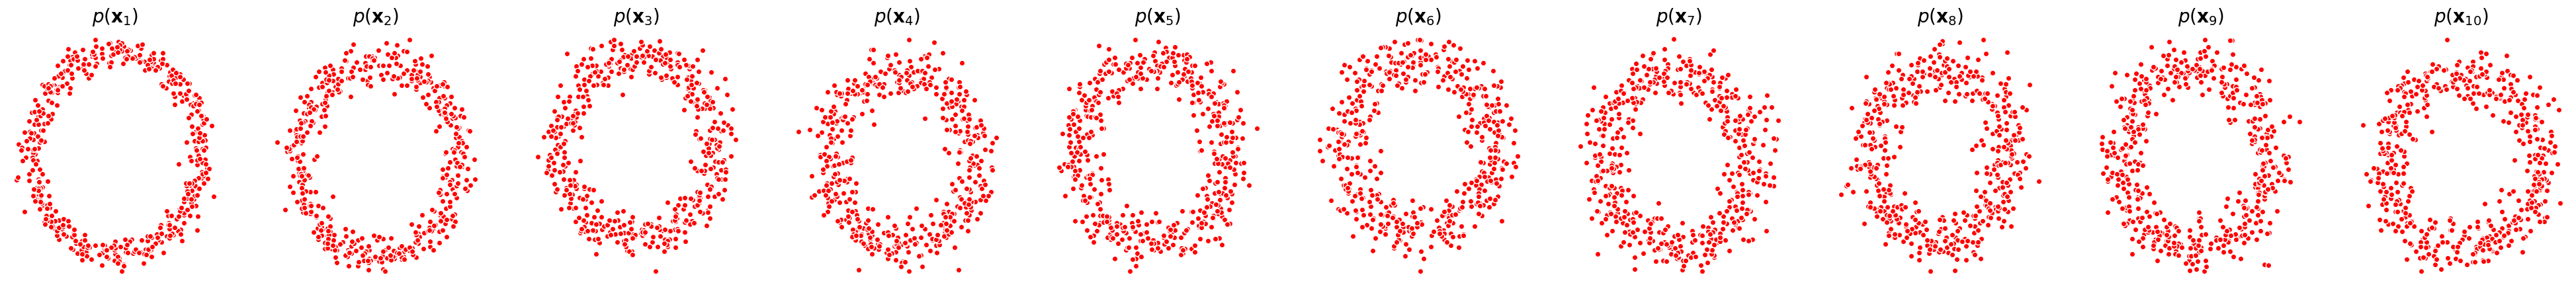

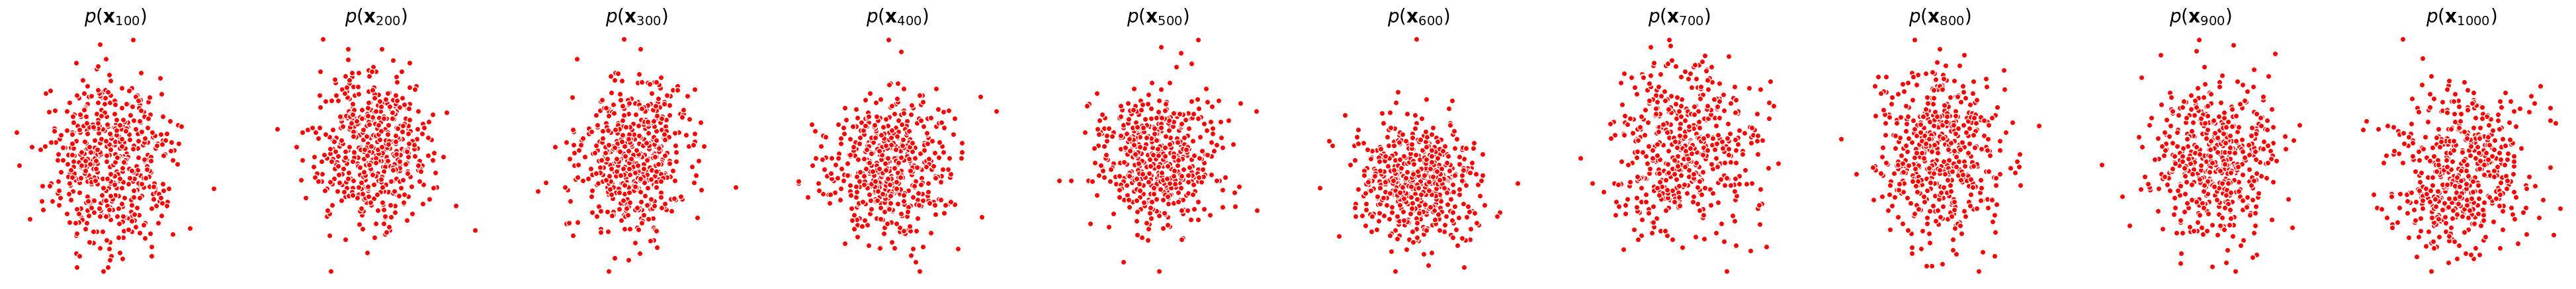

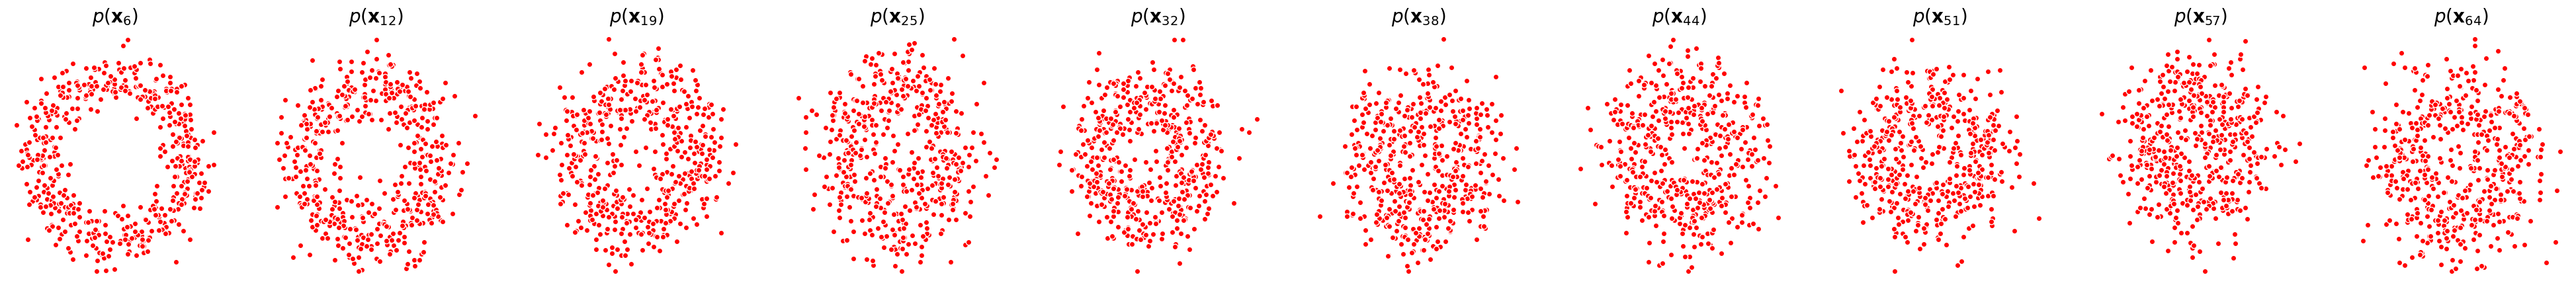

In [9]:
# Too fewer steps
forward_diffusion = plot_forward_diffu(dataset, num_steps=10, beta_start_end=[5e-3, 1e-5])
forward_diffusion.plot(num_shows=10)

# Too many steps
forward_diffusion = plot_forward_diffu(dataset, num_steps=1000, beta_start_end=[5e-3, 1e-5])
forward_diffusion.plot(num_shows=10)

# Suitable hyperparameters
forward_diffusion = plot_forward_diffu(dataset, num_steps=64, beta_start_end=[5e-3, 1e-5])
forward_diffusion.plot(num_shows=10)

# Set the hyperparameters suitable by experiments above
num_steps = 64
beta_start_end = [5e-3, 1e-5]


## Training model

**Parameter setting**
* batch_size: how much data to sample at a time, should not be larger than the total number of data sets.
  * The choice depends on the performance of the computer.
* num_epoch: How many epochs to perform.
  * In practice it can be set to train continuously until the loss converges.

**Training process**
* Hyperparameter pre-processing
* For i in range(num_epoch)
  * Load a batch of data
  * Calculate the loss using the *diffusion_loss_fn* defined in the previous section
  * Calculating gradients, back propagation
  * Adam Optimizer completes the optimization
  * Load another batch of data
  * ...
  * Until all data has been used once
* Generate and plot it when epochs = 1, 100, 1000
* End for

**Training result**
* The output is poor in the first 100 epochs and by the 1000th epochs the inner rules have largely been learned.
  * Our dots are all very close to the circle, which means that the "picture" we drew is very close to the "cat"
  * Each run may be slightly different due to random seeds.
* The loss always oscillates in an interval and cannot converge to a small range.
  * This is due to the specific nature of this dataset, which is too spatially dense.

Training model...
100 tensor(0.8120, grad_fn=<MeanBackward0>)
200 tensor(0.7219, grad_fn=<MeanBackward0>)
300 tensor(0.7768, grad_fn=<MeanBackward0>)
400 tensor(0.5853, grad_fn=<MeanBackward0>)
500 tensor(0.6114, grad_fn=<MeanBackward0>)
600 tensor(0.4895, grad_fn=<MeanBackward0>)
700 tensor(0.5796, grad_fn=<MeanBackward0>)
800 tensor(0.5497, grad_fn=<MeanBackward0>)
900 tensor(0.6484, grad_fn=<MeanBackward0>)
1000 tensor(0.7076, grad_fn=<MeanBackward0>)


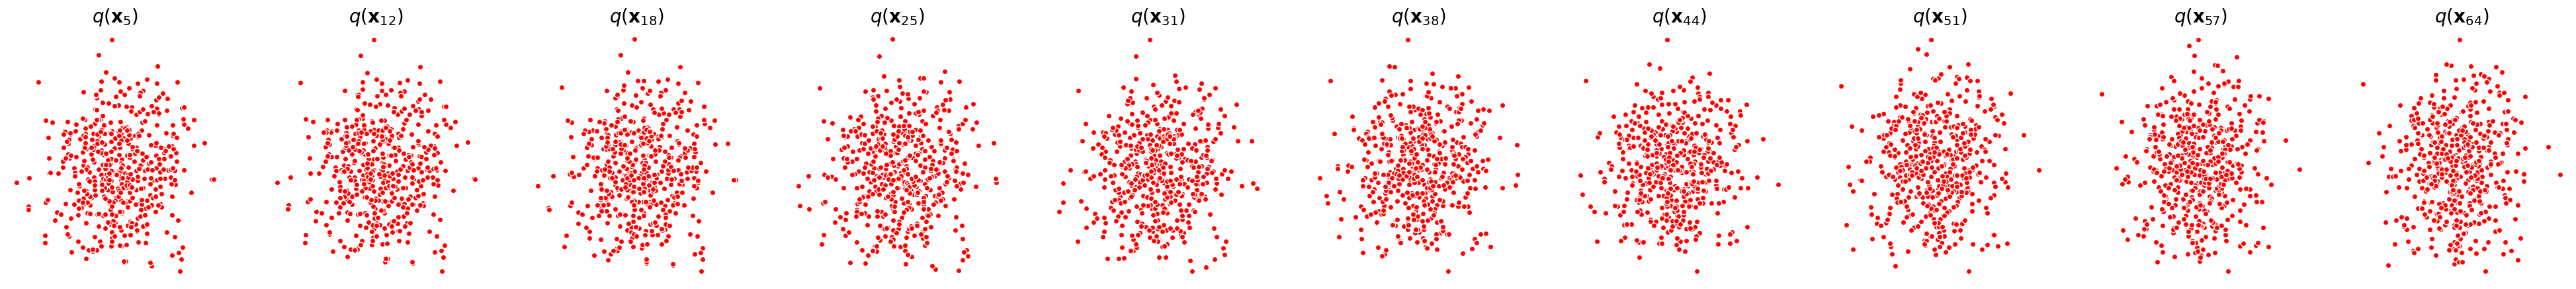

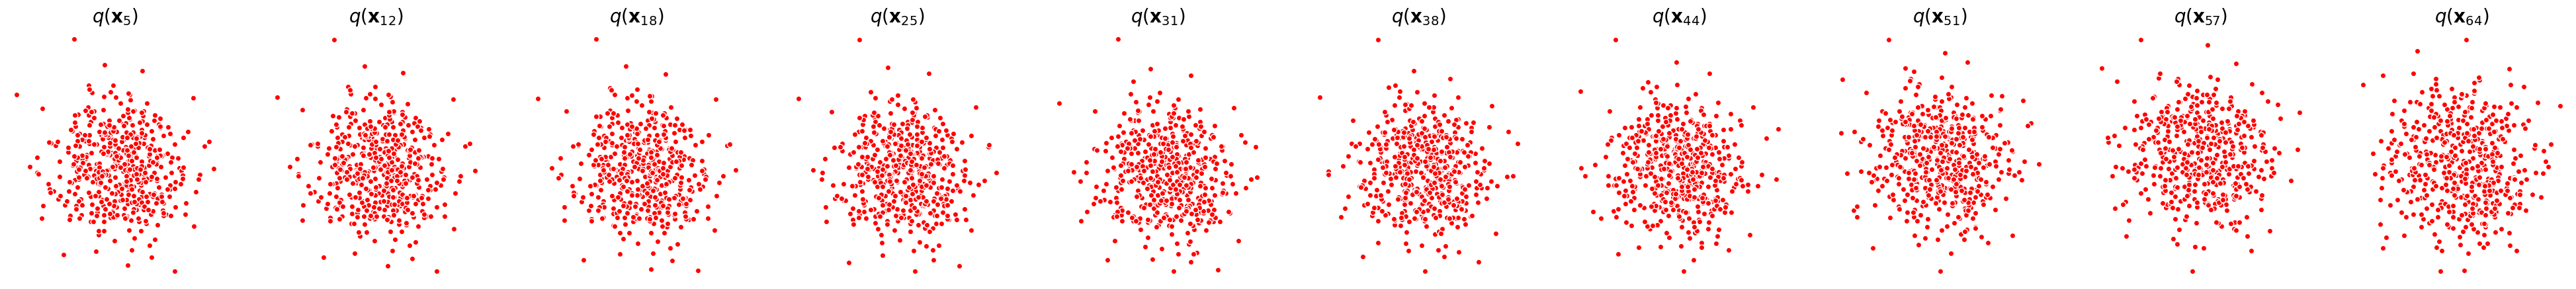

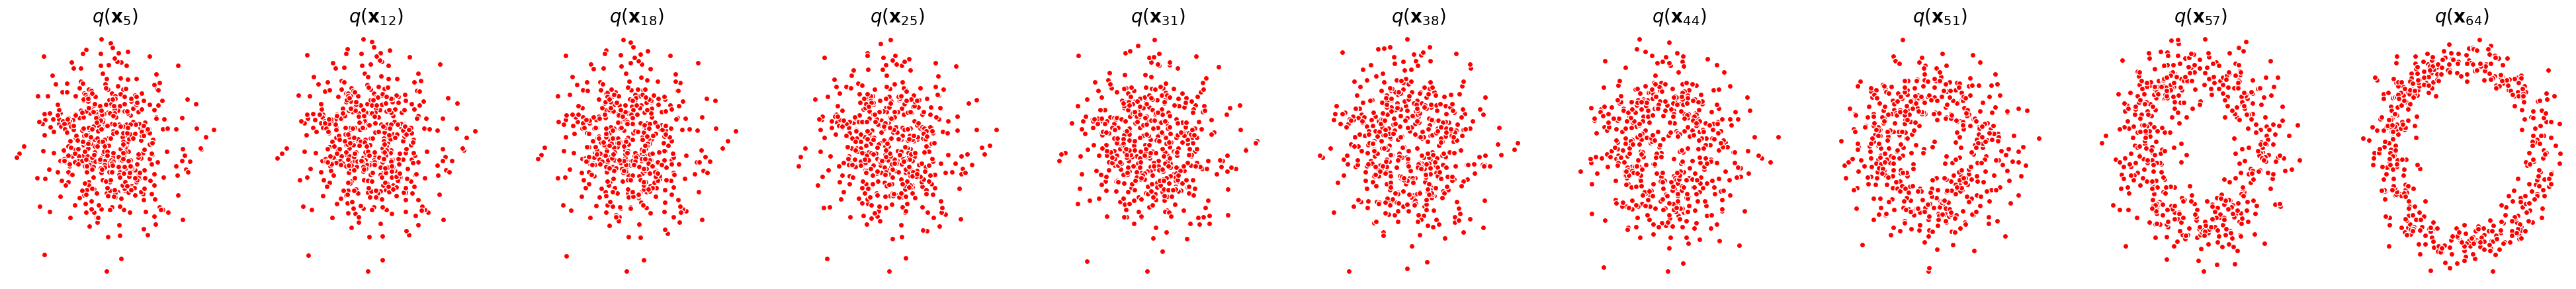

In [10]:
# Set the size of each sample
batch_size = 125

# Set the number of epoch
num_epoch = 1000

# Start training the model
print('Training model...')

# Hyperparameter pre-processing
alphas, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod = hyper_per_pro(num_steps, beta_start_end)

# Convenient sampling with torch
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

# Tell the model the total number of steps
model = MLPDiffusion(num_steps)

# Optimisation by Adam algorithm
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)


for t in range(num_epoch):

    # Each epoch will be optimised several times until all data has been used once
    for _,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,sqrt_alphas_cumprod,sqrt_one_minus_alphas_cumprod,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()

    if((t+1)%100==0):
        # Print loss every 100 epoch
        print(t+1,loss)

    if((t+1)==1):
        # Try to make a generation when epochs = 1
        x_seq = reverse_diffu_loop(model,dataset.shape,num_steps,alphas,sqrt_one_minus_alphas_cumprod)
        reverse_diffusion = plot_reverse_diffu(x_seq)
        reverse_diffusion.plot(num_shows=10)

    if((t+1)==100):
        # Try to make a generation when epochs = 100
        x_seq = reverse_diffu_loop(model,dataset.shape,num_steps,alphas,sqrt_one_minus_alphas_cumprod)
        reverse_diffusion = plot_reverse_diffu(x_seq)
        reverse_diffusion.plot(num_shows=10)

    if((t+1)==1000):
        # Try to make a generation when epochs = 1000
        x_seq = reverse_diffu_loop(model,dataset.shape,num_steps,alphas,sqrt_one_minus_alphas_cumprod)
        reverse_diffusion = plot_reverse_diffu(x_seq)
        reverse_diffusion.plot(num_shows=10)

# CONCLUSION

In summary, a diffusion model divides a complex generative task into smaller parts and solves it step-by-step. The diffusion model itself can be seen as a neural network that identifies noise plus a clever mathematical structure.

## Related work

* It is usually assumed that *Deep Unsupervised Learning using Nonequilibrium Thermodynamics* [SWMG15] presented the diffusion model and DDPM [HJA20] completed the high performance training for the first time.
  * The relationship between them is similar to relationship between Neocognitron and AlexNet.
* In the previous material, we chose $t$ to be discrete. SGM [SSK21] allows $t$ as a continuous variable.
* The authors of the tutorial argue that the design of the diffusion model is influenced by the VAE. Its structure is very similar to that of the diffusion model, except that the training objects are different.
  * In VAE, we train the "underlying laws". Then, it is sampled by using the generator.
  * In the diffusion model, we train the "generator". It is then given a random noise for it to generate.

## Strength

* Better robustness
  * The choice of variational posterior is very difficult during VAE training. 
  * Discriminators for GAN are very difficult to design and train.
* Better presentation ability
  * Normalizing flow requires the model to be an invertible function, so the selection of neural networks is limited.

## Limitations

* The core assumption of the diffusion model is that the noise follows a Gaussian distribution, and the model is invalid if the actual situation violates this assumption.
  * Violations of the Gaussian distribution are almost impossible due to the existence of the *Law of large numbers* and the fact that the Gaussian distribution is the distribution with the highest entropy in continuous space.
* The diffusion model relies heavily on the neural network's ability to recognise noise, and in most cases only the U-Net works.
  * The MLP used in this tutorial only performs well on 2D datasets.
* Poor performance on discrete data sets.
* Multiple rounds of sampling are required for each generation, which means that even when the model training is complete, there is a significant computing power burden during use.
* The diffusion model performs worse than the generative model based on the likelihood function in maximum likelihood estimation. [YZS23]
* Poor data generalisation.
  * Models learning to draw cats does not help in learning to draw dogs.

## Future work

* Finding ways to improve the issues mentioned in **Limitations** are valuable.
* It would be interesting to apply the generative pre-training (decoder-only) techniques used in the GPT series to the diffusion model class. [YZS23]

# References

[HJA20] J. Ho, A. Jain, and P. Abbeel, ‘Denoising Diffusion Probabilistic Models’, Jun. 2020, doi: 10.48550/arXiv.2006.11239.

[SWMG15] J. Sohl-Dickstein, E. A. Weiss, N. Maheswaranathan, and S. Ganguli, ‘Deep Unsupervised Learning using Nonequilibrium Thermodynamics’. arXiv, Nov. 18, 2015. doi: 10.48550/arXiv.1503.03585.

[YZS23] L. Yang et al., ‘Diffusion Models: A Comprehensive Survey of Methods and Applications’. arXiv, Mar. 23, 2023. doi: 10.48550/arXiv.2209.00796.

[SSK21] Y. Song, J. Sohl-Dickstein, D. P. Kingma, A. Kumar, S. Ermon, and B. Poole, ‘Score-Based Generative Modeling through Stochastic Differential Equations’. arXiv, Feb. 10, 2021. doi: 10.48550/arXiv.2011.13456.

[N06] S. Nadarajah, ‘On the linear combination of normal and Laplace random variables’, Computational Statistics, vol. 21, no. 1, pp. 63–71, Mar. 2006, doi: 10.1007/s00180-006-0251-1.
